In [ ]:
!pip install tqdm
!pip install --upgrade torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split

transform = transforms.Compose([transforms.ToTensor()])

# Load the dataset
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split the dataset into three subsets
lengths = [len(mnist) // 3, len(mnist) // 3, len(mnist) - 2*(len(mnist) // 3)]
sample1, sample2, sample3 = random_split(mnist, lengths)

100%|██████████| 9912422/9912422 [00:00<00:00, 115012382.80it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 85547806.37it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 28256846.33it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14744991.31it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# Split test

print(len(sample1))
print(len(sample2))
print(len(sample3))

20000
20000
20000


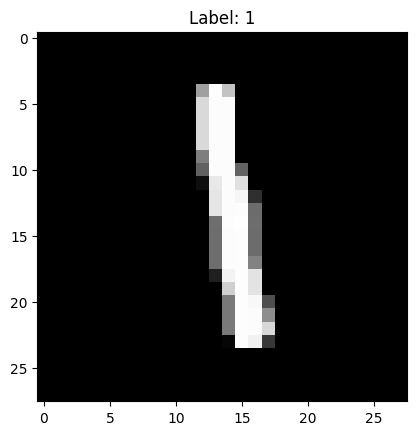

In [ ]:
# Case test
import matplotlib.pyplot as plt

image, label = sample1[0]

# Convert from 1x28x28 to 28x28
image = image.squeeze().numpy()

plt.imshow(image, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch

# Sample model for testing
class CNN(nn.Module):
  """ConvNet -> Max_Pool -> RELU -> ConvNet ->
  Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 20, 5, 1)
    self.conv2 = nn.Conv2d(20, 50, 5, 1)
    self.fc1 = nn.Linear(4*4*50, 500)
    self.fc2 = nn.Linear(500, 10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, 4*4*50)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [ ]:
# Create the initial global model

global_model_fedavg = CNN()
global_model_fedprox = CNN()

# Set up the parameters of training and federated learning
lr = 0.01
local_epochs = 3
global_rounds = 5 # Global rounds here should be larger, 5 is just for faster training

In [ ]:
from torch.utils.data import DataLoader

batch_size = 32

sample1_dataloader = DataLoader(sample1, batch_size=batch_size, shuffle=True)
sample2_dataloader = DataLoader(sample2, batch_size=batch_size, shuffle=True)
sample3_dataloader = DataLoader(sample3, batch_size=batch_size, shuffle=True)

dataloaders = {
  "sample1": sample1_dataloader,
  "sample2": sample2_dataloader,
  "sample3": sample3_dataloader,
}

In [ ]:
def average_weights(state_dicts):
  avg_dict = {}
  for k in state_dicts[0].keys():
    avg_dict[k] = torch.stack([state_dict[k] for state_dict in state_dicts]).mean(dim=0)
  return avg_dict

In [ ]:
def evaluate(model, dataloader):
  # Set model to evaluation
  model.eval()
  correct = 0
  with torch.no_grad():
    for data, target in dataloader:
      output = model(data)
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  accuracy = 100. * correct / len(dataloader.dataset)
  return accuracy

In [ ]:
# Store the accuracies

global_accuracies_fedavg = []
global_accuracies_fedprox = []
local_accuracies_fedavg = {
    "sample1": [],
    "sample2": [],
    "sample3": []
}

local_accuracies_fedprox = {
    "sample1": [],
    "sample2": [],
    "sample3": []
}


In [ ]:
def fedprox_loss_fn(local_model, global_model, mu):
  fedprox_loss = 0.0
  for local_param, global_param in zip(local_model.parameters(), global_model.parameters()):
    fedprox_loss += ((mu / 2) * torch.norm(local_param - global_param) ** 2)
  return fedprox_loss


In [ ]:
# Hyperparameter for FedProx
mu = 0.1

In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

print("\nTraining with FedAvg")

for global_round in range(global_rounds):
  # Show round
  print(f"\nStarting Global Round {global_round+1}/{global_rounds} - FedAvg\n")
  local_models_fedavg = []

  for sample_name, dataloader in dataloaders.items():
    local_model = CNN()
    local_model.load_state_dict(global_model_fedavg.state_dict())

    optimizer = optim.SGD(local_model.parameters(), lr=lr)

    for epoch in range(local_epochs):
      # Wrap dataloader with tqdm
      for data, target in tqdm(dataloader, desc=f"{sample_name} - Epoch {epoch+1}/{local_epochs}"):
        optimizer.zero_grad()
        output = local_model(data)
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()

    local_models_fedavg.append(local_model.state_dict())

    acc = evaluate(local_model, dataloader)
    local_accuracies_fedavg[sample_name].append(acc)

    # FedAvg - average the local models to update the global model
  global_weights = average_weights(local_models_fedavg)
  global_model_fedavg.load_state_dict(global_weights)

  combined_dataset = torch.utils.data.ConcatDataset([sample1, sample2, sample3])
  combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
  # evaluate global model with combined dataset
  global_acc = evaluate(global_model_fedavg, combined_dataloader)
  global_accuracies_fedavg.append(global_acc)

# Training loop for FedProx
print("\nTraining with FedProx")

global_accuracies_fedprox = []
for global_round in range(global_rounds):
  print(f"\nStarting Global Round {global_round+1}/{global_rounds} - FedProx\n")
  local_models_fedprox = []

  for sample_name, dataloader in dataloaders.items():
    local_model = CNN()
    local_model.load_state_dict(global_model_fedprox.state_dict())

    optimizer = optim.SGD(local_model.parameters(), lr=lr)

    #Training loop for FedProx
    for epoch in range(local_epochs):
      for data, target in tqdm(dataloader, desc=f"{sample_name} - Epoch {epoch+1}/{local_epochs}"):
        optimizer.zero_grad()
        output = local_model(data)
        loss = nn.CrossEntropyLoss()(output, target)

        # Add the FedProx loss term
        fedprox_loss = fedprox_loss_fn(local_model, global_model_fedprox, mu)
        loss += fedprox_loss

        loss.backward()
        optimizer.step()

    local_models_fedprox.append(local_model.state_dict())
    acc = evaluate(local_model, dataloader)
    local_accuracies_fedprox[sample_name].append(acc)

  global_weights_fedprox = average_weights(local_models_fedprox)
  global_model_fedprox.load_state_dict(global_weights_fedprox)

  combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
  global_acc = evaluate(global_model_fedprox, combined_dataloader)
  global_accuracies_fedprox.append(global_acc)


Training with FedAvg

Starting Global Round 1/5 - FedAvg



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:21<00:00, 29.44it/s]



Starting Global Round 2/5 - FedAvg



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:22<00:00, 27.30it/s]



Starting Global Round 3/5 - FedAvg



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:23<00:00, 26.47it/s]



Starting Global Round 4/5 - FedAvg



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:23<00:00, 27.08it/s]



Starting Global Round 5/5 - FedAvg



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:22<00:00, 27.64it/s]



Training with FedProx

Starting Global Round 1/5 - FedProx



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.10it/s]



Starting Global Round 2/5 - FedProx



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.18it/s]



Starting Global Round 3/5 - FedProx



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:24<00:00, 25.77it/s]



Starting Global Round 4/5 - FedProx



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:26<00:00, 24.02it/s]



Starting Global Round 5/5 - FedProx



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:24<00:00, 25.11it/s]


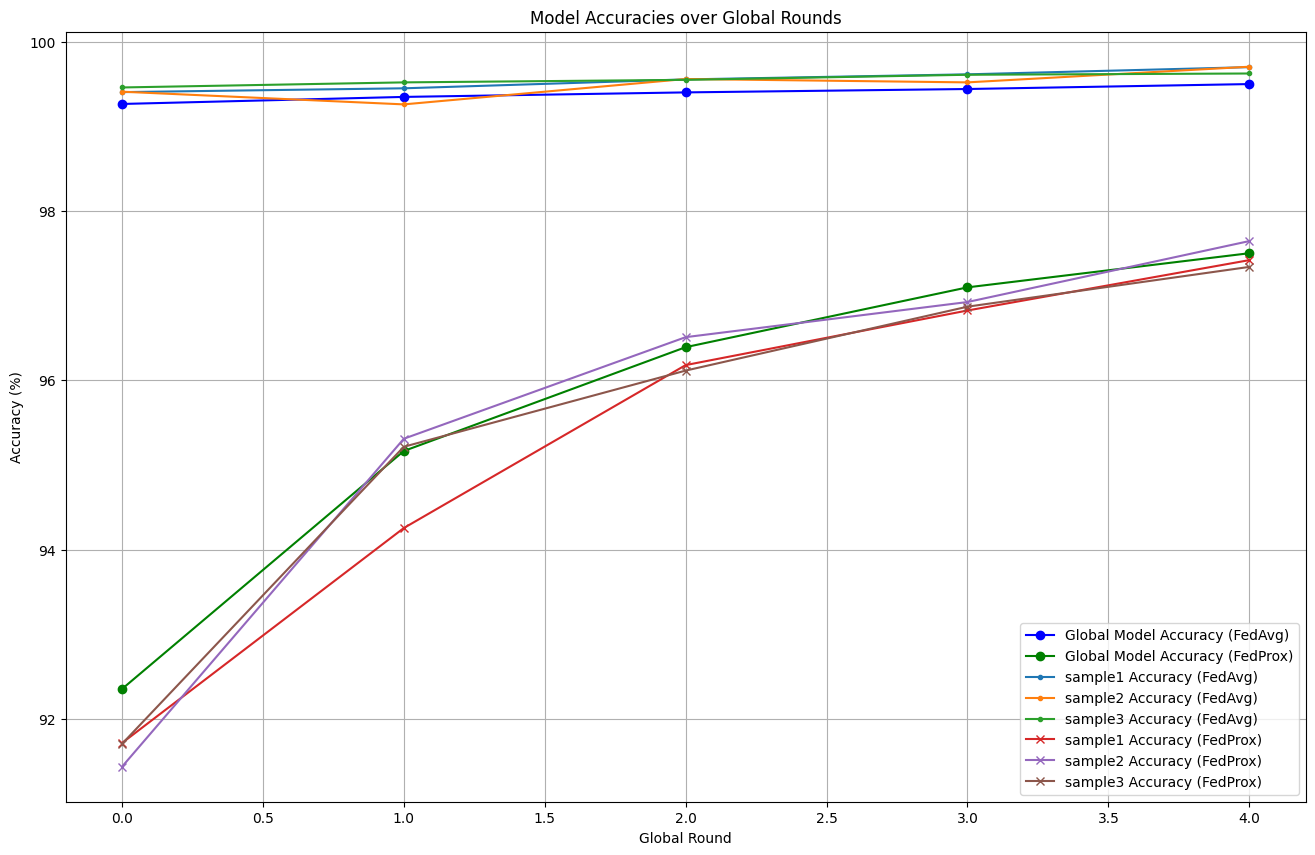

In [ ]:
plt.figure(figsize=(16, 10))

# Plotting global accuracies for both FedAvg and FedProx
plt.plot(global_accuracies_fedavg, label='Global Model Accuracy (FedAvg)', color='blue', marker='o')
plt.plot(global_accuracies_fedprox, label='Global Model Accuracy (FedProx)', color='green', marker='o')

# Plotting local accuracies for FedAvg
for sample_name, accuracies in local_accuracies_fedavg.items():
  plt.plot(accuracies, label=f'{sample_name} Accuracy (FedAvg)', marker='.')

# Plotting local accuracies for FedProx
for sample_name, accuracies in local_accuracies_fedprox.items():
  plt.plot(accuracies, label=f'{sample_name} Accuracy (FedProx)', marker='x')

plt.title('Model Accuracies over Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()



Training with FedProx, mu = 0.1


Starting Global Round 1/5 - FedProx, mu = 0.1



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:24<00:00, 25.48it/s]



Starting Global Round 2/5 - FedProx, mu = 0.1



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:26<00:00, 23.93it/s]



Starting Global Round 3/5 - FedProx, mu = 0.1



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.41it/s]



Starting Global Round 4/5 - FedProx, mu = 0.1



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.43it/s]



Starting Global Round 5/5 - FedProx, mu = 0.1



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:26<00:00, 23.72it/s]



Training with FedProx, mu = 1.0


Starting Global Round 1/5 - FedProx, mu = 1.0



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.18it/s]



Starting Global Round 2/5 - FedProx, mu = 1.0



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:26<00:00, 23.72it/s]



Starting Global Round 3/5 - FedProx, mu = 1.0



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.83it/s]



Starting Global Round 4/5 - FedProx, mu = 1.0



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:25<00:00, 24.24it/s]



Starting Global Round 5/5 - FedProx, mu = 1.0



sample3 - Epoch 3/3: 100%|██████████| 625/625 [00:24<00:00, 25.08it/s]


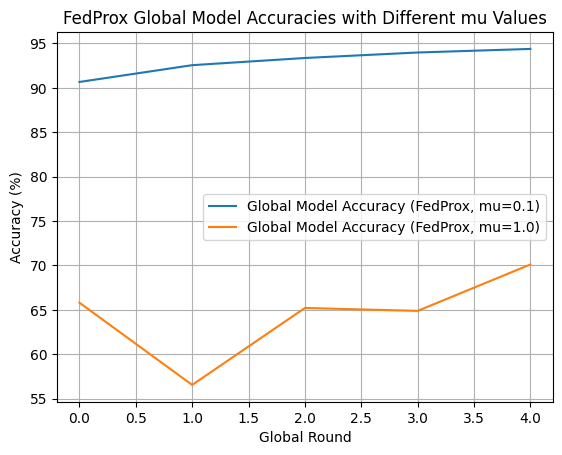

In [ ]:
# Initialize two global models for FedProx
global_model_fedprox_mu_01 = CNN()
global_model_fedprox_mu_10 = CNN()

# Define values for mu
mu_values = [0.1, 1.0]

# Dictionaries to track accuracies for each mu value
global_accuracies_fedprox = {0.1: [], 1.0: []}
local_accuracies_fedprox = {0.1: {"sample1": [], "sample2": [], "sample3": []},
                            1.0: {"sample1": [], "sample2": [], "sample3": []}}

for mu in mu_values:
  print(f"\nTraining with FedProx, mu = {mu}\n")
  global_model = global_model_fedprox_mu_01 if mu == 0.1 else global_model_fedprox_mu_10

  for global_round in range(global_rounds):
    print(f"\nStarting Global Round {global_round+1}/{global_rounds} - FedProx, mu = {mu}\n")
    local_models = []

    for sample_name, dataloader in dataloaders.items():
      local_model = CNN()
      local_model.load_state_dict(global_model.state_dict())

      optimizer = optim.SGD(local_model.parameters(), lr=lr)

      #Training loop for FedProx
      for epoch in range(local_epochs):
        for data, target in tqdm(dataloader, desc=f"{sample_name} - Epoch {epoch+1}/{local_epochs}"):
          optimizer.zero_grad()
          output = local_model(data)
          loss = nn.CrossEntropyLoss()(output, target)

          # Add the FedProx loss term
          fedprox_loss = fedprox_loss_fn(local_model, global_model_fedprox, mu)
          loss += fedprox_loss

          loss.backward()
          optimizer.step()

      local_models.append(local_model.state_dict())

      # Evaluate local model
      acc = evaluate(local_model, dataloader)
      local_accuracies_fedprox[mu][sample_name].append(acc)

    # Aggregate local models
    global_weights = average_weights(local_models)
    global_model.load_state_dict(global_weights)

    # Evaluate global model
    combined_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=False)
    global_acc = evaluate(global_model, combined_dataloader)
    global_accuracies_fedprox[mu].append(global_acc)

# Visualization of results for different mu values
for mu, accuracies in global_accuracies_fedprox.items():
    plt.plot(accuracies, label=f'Global Model Accuracy (FedProx, mu={mu})')

plt.title('FedProx Global Model Accuracies with Different mu Values')
plt.xlabel('Global Round')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [1]:
## FedSGD